## Comparing Landsat and PlanetScope Scenes

A common workflow for analysis is comparing or combining information from multiple sources. This tutorial demonstrates comparing a set of Landsat and PlanetScope scenes.

In this tutorial, we download scenes from the two sensors taken on the same day at the same place, visualize them, resample the Landsat scene to match the pixel resolution and locations of the PlanetScope scene, and perform pixel-by-pixel comparison of their near-infrared bands.

## Install Dependencies and Set up Notebook

In [1]:
import os
import shutil
from subprocess import check_output, STDOUT, CalledProcessError
import urllib.request

import numpy as np
import rasterio
import requests

%matplotlib inline

## Download Scenes

In the [crossovers notebook](../crossovers/ps_l8_crossovers.ipynb), we identified many Landsat/PlanetScope crossovers that occured between January and August 2017. From that list, we are going to download the following set of scenes: 
 - [PSOrthoTile 644787_1056721_2017-07-25_0f52](https://api.planet.com/data/v1/item-types/PSOrthoTile/items/644787_1056721_2017-07-25_0f52/thumb)
 - [Landsat8L1G LC80430332017206LGN00](https://api.planet.com/data/v1/item-types/Landsat8L1G/items/LC80430332017206LGN00/thumb)


|PSOrthoTile                           | Landsat8L1G |
|:------------------------------------:|:-------------------------:|
|![644787_1056721_2017-07-25_0f52][ps] |  ![LC80430332017206LGN00][l8]|

[ps]: images/644787_1056721_2017-07-25_0f52_thumb.png "644787_1056721_2017-07-25_0f52"
[l8]: images/LC80430332017206LGN00_thumb.png "LC80430332017206LGN00"


For the Landsat8L1G scene, we download band 5, which is the NIR band ([ref](https://landsat.usgs.gov/what-are-band-designations-landsat-satellites)).

To download the scenes, we use the planet CLI because it handles activating, waiting for activation, and downloading the file.

We will save the scenes in the `data` folder. This folder isn't tracked by git so the downloaded image file will not bloat our git repository.

### Download PlanetScope Orthotile Scene

In [2]:
# create the data folder if it doesn't exist
data_folder = 'data'
if not os.path.isdir(data_folder): os.mkdir(data_folder)

In [3]:
!planet data download --item-type PSOrthoTile \
                      --asset-type analytic \
                      --string-in id 644787_1056721_2017-07-25_0f52 \
                      --dest data

activating: 0            complete: 0              elapsed: 0                    
paging: False            pending: 0                                             

activating: 0            complete: 0              elapsed: 1                    
paging: False            pending: 0                                             

activating: 0            complete: 0              elapsed: 2                    
paging: False            pending: 0                                             

activating: 1            complete: 0              downloaded: 0.00MB            
downloading: 0           elapsed: 3               paging: False                 
pending: 0                                                                      

activating: 0            complete: 0              downloaded: 0.00MB            
downloading: 1           elapsed: 4               paging: False                 
pending: 0                                                                      

activating: 0          

In [4]:
# store the image filename for processing and make sure the file exists
pl_filename = os.path.join('data', '644787_1056721_2017-07-25_0f52_BGRN_Analytic.tif')
print(pl_filename)
assert os.path.isfile(pl_filename)

data/644787_1056721_2017-07-25_0f52_BGRN_Analytic.tif


### Download Landsat NIR Band

Landsat is distributed with each asset as an individual band. Band 5 is the NIR band. Since we only plan on using the NIR band, we will download just that asset.

NOTE: The command below should work, but currently there is a bug in the planet CLI.
Until that is fixed, use the curl command to download the asset from the endpoint directly.

In [5]:
# !planet data download --item-type Landsat8L1G \
#                       --asset-type analytic_b5 \
#                       --string-in id LC80430332017206LGN00 \
#                       --dest data
# !ls -l --block-size=M data

In [6]:
# The long way of downloading an asset. Doesn't use the planet CLI

def get_auth():
    auth = (os.environ['PL_API_KEY'], '')
    return auth

def get_asset_info(asset):
    auth = get_auth()
    item_assets_url = 'https://api.planet.com/data/v1/item-types/Landsat8L1G/items/LC80430332017206LGN00/assets/'
    r = requests.get(item_assets_url, auth=auth)
    assert r.status_code == 200
    assets_resp = r.json()

    return assets_resp[asset]

def activate(asset):
    asset_info = get_asset_info(asset)
    activation_link = asset_info['_links']['activate']
    auth = get_auth()
    r = requests.post(activation_link, auth=auth)
    assert r.status_code == 204

def download(asset, path):
    if not os.path.isfile(path):
        asset_info = get_asset_info(asset)
        download_link = asset_info['location']
        urllib.request.urlretrieve(download_link, path)

asset = 'analytic_b5'
activate(asset)

# it may take a while for the asset to be activated. If this fails, wait a while and rerun
landsat_filename = os.path.join('data', 'LC80430332017206LGN00_{}.tif'.format(asset))
download(asset, landsat_filename)

In [7]:
# run this to confirm image was downloaded
# !ls -l --block-size=M data

In [8]:
# store the Landsat band filename for processing and make sure the file exists
l8_nir_orig_filename = os.path.join('data', 'LC80430332017206LGN00_analytic_b5.tif')
print(l8_nir_orig_filename)
assert os.path.isfile(l8_nir_orig_filename)

data/LC80430332017206LGN00_analytic_b5.tif


## Warp Landsat Scene to Planet Scene

For pixel-by-pixel comparison of the Landsat and Planet scenes, the two scenes must have the same extents, the pixels must be the same size, and the pixels must exactly overlap each other. This can all be achieved by warping one scene to the other scene. We warp the Landsat scene to the Planet scene because the Planet scene is much higher resolution than the Landsat scene and we want to use the highest resolution possible for our comparison.

The GDAL command-line interface, specifically [gdalwarp](http://www.gdal.org/gdalwarp.html), is the easiest way to warp one image to another image.

In [10]:
def prepare_l8_band(band_filename, dst_filename, out_filename):
    '''Project, crop, and resample landsat 8 band to match dst_filename image.'''
    
    # we use 'cubic' method for interpolation because band represents continuous data
    method = 'cubic'
    
    with rasterio.open(band_filename, 'r') as src:
        with rasterio.open(dst_filename, 'r') as dst:
            # crop
            crop_options = _gdalwarp_crop_options(dst.bounds, dst.crs)

            # resample
            width, height = dst.shape
            resample_options = _gdalwarp_resample_options(str(width), str(height), method)

            options = crop_options + resample_options
            
            # run gdalwarp
            _gdalwarp(band_filename, out_filename, options)

def _gdalwarp_crop_options(bounds, crs):
    xmin, ymin, xmax, ymax = [str(b) for b in bounds]
    return ['-te', xmin, ymin, xmax, ymax]

def _gdalwarp_resample_options(width, height, technique):
    # for technique options, see: http://www.gdal.org/gdalwarp.html
    return ['-ts', width, height, '-r', technique]

def _gdalwarp(input_filename, output_filename, options):
    commands = _gdalwarp_commands(input_filename, output_filename, options)

    # print error if one is encountered
    # https://stackoverflow.com/questions/29580663/save-error-message-of-subprocess-command
    try:
        output = check_output(commands, stderr=STDOUT)
    except CalledProcessError as exc:
        print(exc.output)

def _gdalwarp_commands(input_filename, output_filename, options):
    commands = ['gdalwarp'] + options + \
               ['-overwrite',
                input_filename,
                output_filename]
    print(' '.join(commands))
    return commands

l8_nir_filename = os.path.join('data', 'LC80430332017206LGN00_analytic_b5_warped.tif')
prepare_l8_band(l8_nir_orig_filename, pl_filename, l8_nir_filename)

gdalwarp -te 643500.0 4223500.0 668500.0 4248500.0 -ts 8000 8000 -r cubic -overwrite data/LC80430332017206LGN00_analytic_b5.tif data/LC80430332017206LGN00_analytic_b5_warped.tif


## Load and Visualize NIR Bands

Before moving on to comparing the NIR bands, we load the NIR bands from each scene, and visualize the bands.

Instead of including a huge chunk of code for visualizing the NIR band, we put that code in a local script ([visual.py](visual.py)) and import here

In [11]:
import visual

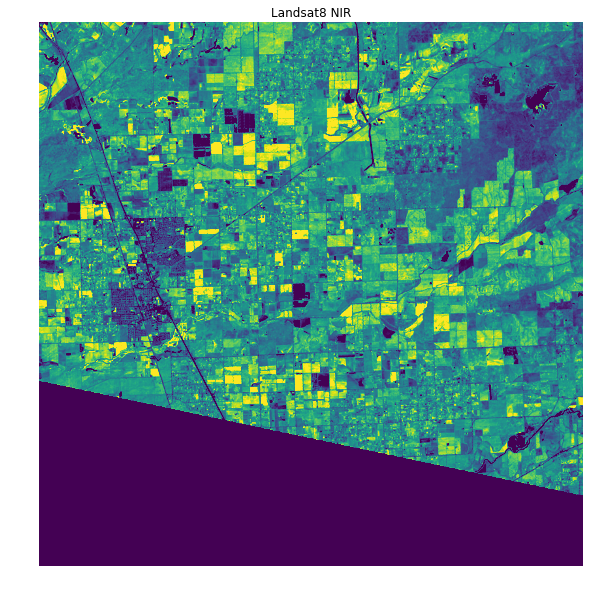

In [12]:
def load_l8_nir():
    with rasterio.open(l8_nir_filename, 'r') as src:
        nir_band = src.read()[0]
        mask = nir_band == 0 #src.read_masks()[0] == 0
    return np.ma.array(nir_band, mask=mask)

l8_nir_band = load_l8_nir()
visual.plot_image([l8_nir_band], title='Landsat8 NIR')

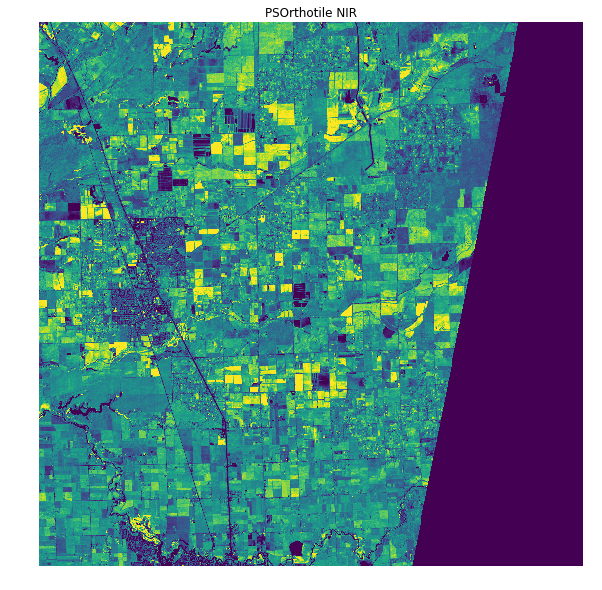

In [13]:
def load_pl_nir():
    with rasterio.open(pl_filename, 'r') as src:
        band_num = 3
        nir_band = src.read()[band_num]
        mask = nir_band == 0 
#         mask = src.read_masks()[band_num] == 0
    return np.ma.array(nir_band, mask=mask)

pl_nir_band = load_pl_nir()
visual.plot_image([pl_nir_band], title='PSOrthotile NIR')

## Compare NIR Bands

In [14]:
def normalize(ndarray, old_min=None, old_max=None, new_min=0, new_max=1):
    old_min = ndarray.min()
    old_max = ndarray.max()

    # https://en.wikipedia.org/wiki/Normalization_(image_processing)
    return (ndarray.astype(np.float) - old_min) * (new_max - new_min) / (old_max - old_min) + new_min

In [15]:
diff_band = normalize(l8_nir_band) - normalize(pl_nir_band)
diff_band.mask = np.any([l8_nir_band.mask, pl_nir_band.mask], axis=0)

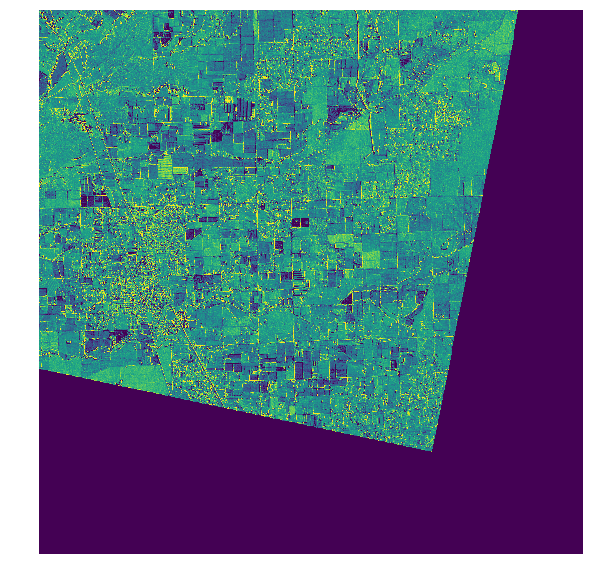

In [16]:
visual.plot_image([diff_band])